# Transfer Learning for Detecting Galaxy Mergers

Transfer learning is a method commonly used for tasks, where data is limited to effectively train a neural network from scratch. For these types of tasks, an already trained neural network from a similar domain can be used to extract meaningful features, and a new linear classifier (usually the last layer of a neural network) can be trained on the extracted features.

In this notebook, we are going to demonstrate how linear SVM training on the PYNQ can be used as part of a transfer learning pipeline. Our data set consists of astronomy images showing galaxies, and the images can be classified in two classes: The ones containing merging galaxies and the ones that do not. 

## Extracting features using InceptionV3

As our feature extraction network, we use the InceptionV3, that has been trained on ImageNet ILSVRC 2012 data set. We use the output of its last pooling layer to obtain 2048 features per input image. We write the extracted features to a file in the libsvm format (label index0:feature0 index1:feature1 ... index2047:feature2047). We have already performed this process for galaxy images and created both training and testing data sets, that you can download using the following script:

In [12]:
!./get_galaxymerger.sh

[galaxy_train] Nothing to do. Data is there.
[galaxy_test] Nothing to do. Data is there.
--2017-11-21 12:00:12--  https://polybox.ethz.ch/index.php/s/nzx2LmstzuKLp1d/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.228, 129.132.71.230, 129.132.71.227, ...
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32001 (31K) [image/jpeg]
Saving to: ‘download’

download            100%[=====================>]  31.25K  --.-KB/s   in 0.003s 

2017-11-21 12:00:13 (10.4 MB/s) - ‘download’ saved [32001/32001]

--2017-11-21 12:00:13--  https://polybox.ethz.ch/index.php/s/yG3vaVfFQLubMtP/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.229, 129.132.71.228, 129.132.71.230, ...
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35815 (35K) [image/jpeg]
Saving to: ‘download’

download            100%

merging galaxies:


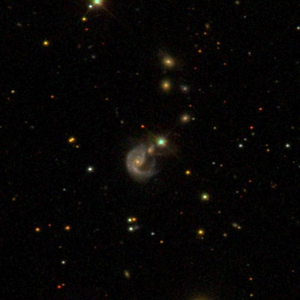

no merging:


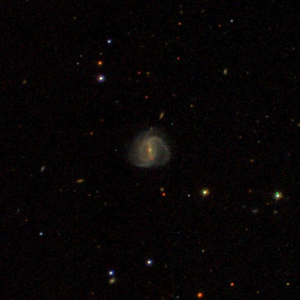

In [22]:
from PIL import Image
from IPython.display import display

merger = Image.open('./galaxymerger/merger.jpeg')
non_merger = Image.open('./galaxymerger/non_merger.jpeg')
print('merging galaxies:')
display(merger.resize((300,300), Image.ANTIALIAS) )
print('no merging:')
display(non_merger.resize((300,300), Image.ANTIALIAS) )

## Doing transfer learning on your own image data sets

Similar to how we extracted features from galaxy images using the InceptionV3, you can perform the same process on your own image data sets using the script "ZipML-PYNQ/zipml/inception-expand-any.py". Before using the script, you need to first install Tensorflow. After that, you can use the script to create your own data sets containing features extracted from images, and then train linear classifiers on them. Since the feature extraction requires a forward pass over a complex neural network such as InceptionV3, we recommend to perform this step on a larger machine where Tensorflow is installed.

In the following, we will cover the training of linear classifiers on PYNQ.

## 1. Instantiate ZipML_SGD

First, we instantiate a ZipML_SGD object, that we will use for training and inference.

In [23]:
import zipml
import numpy as np
import time

Z = zipml.ZipML_SGD(on_pynq=1, bitstreams_path=zipml.BITSTREAMS, ctrl_base=0x41200000, dma_base=0x40400000, dma_buffer_size=32*1024*1024)

floatFSGD.bit is loaded
Got sgd_ctrl!
Got sgd_dma!
Allocated buffer of size: 33554432 bytes


## 2. Load and prepare the data

We load the data that is formatted in libsvm format (label feature_index1:feature1 feature_index2:feature2 ...). Then, we perform a normalization on the features of the data set. We binarize the labels, since we are aiming to perform binary classification (merger vs. non-merger).

In [26]:
start = time.time()
Z.load_libsvm_data('./galaxymerger/galaxy_train.dat', 3000, 2048)
print('a loaded, time: ' + str(time.time()-start) )
Z.a_normalize(to_min1_1=0, row_or_column='r')
Z.b_binarize(1)
print('b binarized for ' + str(1.0) + ", time: " + str(time.time()-start) )

# Set training related parameters
num_epochs = 50
step_size = 1.0/(1 << 8)
cost_pos = 1.0
cost_neg = 1.0

num_values_one_row: 2052
a loaded, time: 143.14256834983826
b binarized for 1.0, time: 147.30051708221436


## 3. Full precision training using the CPU

In [29]:
start = time.time()
x_history_CPU = Z.L2SVM_SGD(num_epochs, step_size, cost_pos, cost_neg, 0, 1)
print('Training time: ' + str(time.time()-start) )
initial_loss = Z.calculate_L2SVM_loss(np.zeros(Z.num_features), cost_pos, cost_neg, 0, 1)
print('Initial loss: ' + str(initial_loss))
for e in range(0, num_epochs):
	loss = Z.calculate_L2SVM_loss(x_history_CPU[:,e], cost_pos, cost_neg, 0, 1)
	print('Epoch ' + str(e) + ' loss: ' + str(loss) )

Training time: 138.7636377811432
Initial loss: 1500.0
Epoch 0 loss: 1137.75045927
Epoch 1 loss: 1049.07313632
Epoch 2 loss: 1000.47278334
Epoch 3 loss: 966.036730145
Epoch 4 loss: 939.246777839
Epoch 5 loss: 917.450934631
Epoch 6 loss: 899.025467674
Epoch 7 loss: 883.094544104
Epoch 8 loss: 869.085181353
Epoch 9 loss: 856.648445663
Epoch 10 loss: 845.521243348
Epoch 11 loss: 835.419474862
Epoch 12 loss: 826.163458857
Epoch 13 loss: 817.618447882
Epoch 14 loss: 809.691277922
Epoch 15 loss: 802.345813512
Epoch 16 loss: 795.457953599
Epoch 17 loss: 788.975640079
Epoch 18 loss: 782.837166213
Epoch 19 loss: 776.956810399
Epoch 20 loss: 771.375123223
Epoch 21 loss: 766.063599213
Epoch 22 loss: 760.998607585
Epoch 23 loss: 756.153933071
Epoch 24 loss: 751.50699819
Epoch 25 loss: 747.042243425
Epoch 26 loss: 742.745308602
Epoch 27 loss: 738.603606759
Epoch 28 loss: 734.605658455
Epoch 29 loss: 730.744772982
Epoch 30 loss: 727.0111745
Epoch 31 loss: 723.397173893
Epoch 32 loss: 719.900866681
Ep

## 4. Full precision training using the FPGA

In [30]:
start = time.time()
Z.configure_SGD_FPGA(num_epochs, step_size, cost_pos, cost_neg, 1, 1.0)
x_history_FPGA = Z.SGD_FPGA(num_epochs)
print('Training time: ' + str(time.time()-start) )
initial_loss = Z.calculate_L2SVM_loss(np.zeros(Z.num_features), cost_pos, cost_neg, 0, 1)
print('Initial loss: ' + str(initial_loss))
for e in range(0, num_epochs):
	loss = Z.calculate_L2SVM_loss(x_history_FPGA[:,e], cost_pos, cost_neg, 0, 1)
	print('Epoch ' + str(e) + ' loss: ' + str(loss) )

Sent
Config Received
0x20
0x20000
0x3b800000
0x3b800000
0x3f800000
0x801
0xbb8
0x32
0x3b800000
self.data_start_index: 0, self.data_end_index: 6156000
bytes_for_model: 8200
Training time: 2.72277569770813
Initial loss: 1500.0
Epoch 0 loss: 1141.09338708
Epoch 1 loss: 1052.16817194
Epoch 2 loss: 1003.76512265
Epoch 3 loss: 969.406197828
Epoch 4 loss: 942.651944349
Epoch 5 loss: 920.795139731
Epoch 6 loss: 902.312971485
Epoch 7 loss: 886.33561039
Epoch 8 loss: 872.278585181
Epoch 9 loss: 859.886052415
Epoch 10 loss: 848.737563573
Epoch 11 loss: 838.606207679
Epoch 12 loss: 829.324077083
Epoch 13 loss: 820.750261921
Epoch 14 loss: 812.851450258
Epoch 15 loss: 805.492012284
Epoch 16 loss: 798.603099155
Epoch 17 loss: 792.124802517
Epoch 18 loss: 786.015188366
Epoch 19 loss: 780.230517961
Epoch 20 loss: 774.719392181
Epoch 21 loss: 769.401946764
Epoch 22 loss: 764.323065775
Epoch 23 loss: 759.464598559
Epoch 24 loss: 754.809229336
Epoch 25 loss: 750.346595906
Epoch 26 loss: 746.062608316
Epo

The training time with the CPU is 138 seconds and with the FPGA just around 3 seconds. We see that the custom logic on the FPGA provides a very efficient way of performing stochastic gradient descent for linear models.

## 5. Testing the trained models

Now that we have trained our model on features that were extracted from galaxy images, we can run binary classification on a test data set and classify images as containing or not containing galaxy mergers.

In [33]:
Z.load_libsvm_data('./galaxymerger/galaxy_test.dat', 1000, 2048)
Z.a_normalize(to_min1_1=0, row_or_column='r')
Z.b_binarize(1)

num_values_one_row: 2052


In [34]:
matches = Z.binary_classification(x_history_FPGA[:,e])
print('matches ' + str(matches) + ' out of ' + str(Z.num_samples) + ' samples.')

matches 796 out of 1000 samples.


We reach around 80% accuracy for detecting galaxy mergers.